In [157]:
import pandas as pd
import matplotlib.pyplot as plt

In [158]:
df = pd.read_csv("data.csv")   # 文件路径可以相对或绝对

追涨

In [ ]:
# 追涨选股

def find_latest_stocks(current_df, latest_date):

    # 2. 在最新日期那一天筛选 comprehensive_score 在 10~15 之间
    filtered = df[
        (df['date'] == latest_date) &
        (current_df['comprehensive_score'] >= 15) &
        (current_df['comprehensive_score'] <= 40) &

        # ② 动能必须顺势增强：3日 > 5日 > 10日
        
        (current_df['comprehensive_score_5_days'] > current_df['comprehensive_score_10_days']) &

        # ③ 不要高潮（避免到达 60–100 的高危区域）
        (current_df['comprehensive_score_20_days'] <= 40) &

        # ④ SMA 趋势明显加强（>15 为强趋势区）
        (current_df['sma_score'] > 15) &

        # ⑤ 价格稳站在 VWAP 上（趋势确认）
        (current_df['vwap_score'] > 5) &

        # ⑥ 资金流向正面（拒绝资金流出）
        (current_df['mfi_score'] >= 0) 

        # ⑦ 大盘行情偏多：避免系统性回调日
        # &(current_df['market_avg_comprehensive_5_days'] > 0) 
        # &(current_df['market_avg_comprehensive_10_days'] > 5) 
    ]

    # 3. 只取 ticker_id 列
    result = filtered['ticker_id'].unique()

    print(result)

    return result

df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True)
latest_date = df['date'].max()
# latest_date = '2025-11-21 00:00:00'

result = find_latest_stocks(df, latest_date)

回踩函数

In [174]:
# 回踩筛选函数
def find_pullback_stocks(df, latest_date):

    # 过滤到最新一天的数据（与你原来风格完全一致）
    today = df[df['date'] == latest_date].copy()

    # 重新计算 volume_ma5（只能在 df 上算，不会破坏 today）
    df['volume_ma5'] = df.groupby('ticker_id')['volume'].transform(
        lambda x: x.rolling(5, min_periods=1).mean()
    )

    # 为了比较上一日指标，这里提前准备 shift
    df['rsi_prev'] = df.groupby('ticker_id')['rsi_score'].shift(1)
    df['macd_prev'] = df.groupby('ticker_id')['macd_score'].shift(1)
    df['comp_prev'] = df.groupby('ticker_id')['comprehensive_score'].shift(1)
    df['prev_close'] = df.groupby('ticker_id')['close'].shift(1)

    # 将 shift 结果合并回 today（按 index 对齐）
    today['volume_ma5'] = df['volume_ma5'].loc[today.index]
    today['rsi_prev'] = df['rsi_prev'].loc[today.index]
    today['macd_prev'] = df['macd_prev'].loc[today.index]
    today['comp_prev'] = df['comp_prev'].loc[today.index]
    today['prev_close'] = df['prev_close'].loc[today.index]

    # --- 回踩筛选逻辑（全部基于 comprehensive_indicator 的列） ---
    filtered = today[

        # ① 必须是上涨趋势中
        (today['close'] > today['close_ma20']) &
        (today['close_ma10'] > today['close_ma20']) &
        (today['comprehensive_score_20_days'] > 0) &

        # ② 正在回踩（跌破 5MA，但仍靠近 20MA）
        (today['close'] < today['close_ma5']) &
        (today['close'] >= today['close_ma20'] * 0.98) &

        # ③ 缩量回踩
        (today['volume'] < today['volume_ma5']) &

        # ④ 排除暴跌
        (((today['close'] / today['prev_close']) - 1) > -0.08) &

        # ⑤ 指标出现反弹迹象
        (
            (today['rsi_score'] > today['rsi_prev']) |
            (today['macd_score'] > today['macd_prev']) |
            (today['comprehensive_score'] > today['comp_prev'])
        ) &

        # ⑥ 资金流入（mfi_score ≥ 0）
        (today['mfi_score'] >= 0) &

        # ⑦ 在 VWAP 上（强势趋势确认）
        (today['vwap_score'] >= 0)
    ]

    result = filtered['ticker_id'].unique()
    print(result)
    return result

df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True)
latest_date = df['date'].max()   # last day 在外面求
# latest_date = '2025-05-07 00:00:00'

result = find_pullback_stocks(df, latest_date)


['ABBV' 'PODD' 'SPFI']


抄底


In [175]:
# 抄底筛选函数

def find_bottom_stocks_v3(df: pd.DataFrame, latest_date):

    # 确保排序稳定
    df = df.sort_values(['ticker_id', 'date']).copy()

    # ========= 1. 生成前一天的字段（shift） =========
    g = df.groupby('ticker_id')
    df['prev_close'] = g['close'].shift(1)
    df['prev_score'] = g['comprehensive_score'].shift(1)
    df['prev_macd']  = g['macd_score'].shift(1)

    # ========= 2. 条件：深度下跌 / 超卖（宽松版） =========
    oversold = (
        (df['rsi_score']   <= -20) &
        (df['stoch_score'] <= -65) &
        (df['bb_score']    <= -65) |
        (df['mfi_score']   <= -65)
    )

    # ========= 3. 条件：确实在下跌趋势中 =========
    downtrend = (
        (df['close']      < df['close_ma20']) &
        (df['close_ma10'] < df['close_ma20'])
    )

    # ========= 4. 条件：止跌 / 动能减弱（右侧轻微企稳） =========
    right_side = (
        (df['close'] >= df['prev_close']) &      # 今天不再明显继续跌
        (df['comprehensive_score'] > df['prev_score']) | # 综合评分开始回升
        (df['macd_score'] > df['prev_macd']*1.02)             # MACD 评分回升
    )

    # ========= 5. 条件：不能是继续暴跌 =========
    daily_ret = (df['close'] / df['prev_close'] - 1)
    not_crash = daily_ret > -0.10   # 当天跌幅不能超过 -10%

    # ========= 6. 条件：资金不要极端流出 =========
    money_ok = df['mfi_score'] >= -50

    # ========= 7. 只看最新一天 + 综合条件 =========
    is_latest_day = df['date'] == latest_date

    final_mask = (
        is_latest_day &
        oversold &
        downtrend &
        right_side &
        not_crash &
        money_ok
    )

    bottom_tickers = df.loc[final_mask, 'ticker_id'].unique()
    return bottom_tickers



df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True)
latest_date = df['date'].max()   # last day 在外面求
# latest_date = '2025-04-04 00:00:00'

result = find_bottom_stocks_v3(df, latest_date)
print(result)

['ACM' 'AMBA']


卖出

In [165]:
# 卖出信号函数 v1
def sell_signal_v1(df: pd.DataFrame, latest_date):

    # —— 0. 确保排序 ——
    df = df.sort_values(['ticker_id', 'date']).copy()

    g = df.groupby('ticker_id')
    df['prev_close'] = g['close'].shift(1)
    df['prev_score'] = g['comprehensive_score'].shift(1)
    df['prev_macd']  = g['macd_score'].shift(1)

    # ===========================
    # 1. 超买（可能到顶部区域）
    # ===========================
    overbought = (
        (df['rsi_score']   >= 30) &
        (df['stoch_score'] >= 70) &
        (df['bb_score']    >= 70) &
        (df['mfi_score']   >= 20)
    )

    # ===========================
    # 2. 上涨动能衰减（右侧转弱信号）
    # ===========================
    momentum_down = (
        (df['comprehensive_score'] < df['prev_score']) |       # 综合评分开始走弱
        (df['macd_score'] < df['prev_macd'] * 0.98)            # MACD 轻微走弱
    )

    # ===========================
    # 3. 价格掉头（反转信号）
    # ===========================
    price_reversal = (
        (df['close'] < df['prev_close']) &     # 今天转跌
        (df['close'] < df['close_ma10'])       # 跌破短期均线
    )

    # ===========================
    # 4. 强制止损条件（避免深踩）
    # ===========================
    daily_ret = df['close'] / df['prev_close'] - 1
    stop_loss = daily_ret <= -0.05               # 当天 -5% 强平

    # ===========================
    # 5. 最新日期
    # ===========================
    is_latest_day = df['date'] == latest_date

    final_mask = (
        is_latest_day &
        (
            overbought         # 1）顶部区域
            # momentum_down       # 2）动能转弱
            # price_reversal     # 3）价格反转
            # stop_loss             # 4）止损
        )
    )

    sell_tickers = df.loc[final_mask, 'ticker_id'].unique()
    return sell_tickers


df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True)
latest_date = df['date'].max()   # last day 在外面求
latest_date = '2025-11-12 00:00:00'

result = sell_signal_v1(df, latest_date)
print(result)


['AEP' 'ALB' 'ALL' 'AMBA' 'AMGN' 'APPN' 'ARGX' 'BK' 'BMY' 'DD' 'FDX' 'GS'
 'HASI' 'JPM' 'KO' 'LLY' 'LVMUY' 'MRK' 'NTRA' 'ONC' 'REGN' 'RIVN' 'ROIV'
 'ROK' 'SCHW' 'SNAP' 'SNDK' 'TMO' 'WELL' 'XPEV' 'YETI']


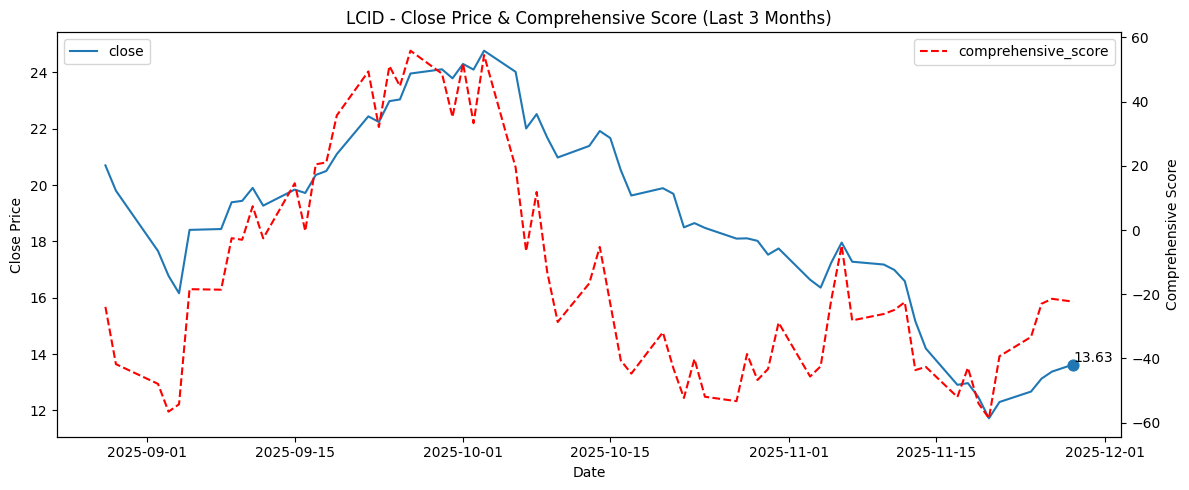

In [147]:
def plot_stock_data(df, result, latest_date):

    # 确保 date 是 datetime 类型
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

    # 只取 result 这些股票的数据
    plot_df = df[df['ticker_id'].isin(result)]

    # 最近 3 个月
    three_months_ago = latest_date - pd.DateOffset(months=3)

    for ticker in result:

        # 过滤数据
        tdf = plot_df[plot_df['ticker_id'] == ticker].copy()
        tdf = tdf[tdf["date"] >= three_months_ago].sort_values("date")

        if tdf.empty:
            continue

        plt.figure(figsize=(12, 5))

        # 画 close
        ax1 = plt.gca()
        ax1.plot(tdf['date'], tdf['close'], label='close')
        ax1.set_xlabel("Date")
        ax1.set_ylabel("Close Price")

        # ⭐ 标出最后一天的 close price
        last_date = tdf['date'].iloc[-1]
        last_close = tdf['close'].iloc[-1]

        ax1.scatter(last_date, last_close, s=60)  # 画点
        ax1.text(
            last_date,
            last_close,
            f"{last_close:.2f}",
            fontsize=10,
            ha='left',
            va='bottom'
        )

        # 画综合评分
        ax2 = ax1.twinx()
        ax2.plot(tdf['date'], tdf['comprehensive_score'],
                 linestyle='--',
                 label='comprehensive_score',
                 color='red')
        ax2.set_ylabel("Comprehensive Score")

        ax1.set_title(f"{ticker} - Close Price & Comprehensive Score (Last 3 Months)")

        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

latest_date = df['date'].max()
plot_stock_data(df, result, latest_date)
